In [47]:
import boto3
from boto3.dynamodb.conditions import Key, Attr
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
import collections
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from scipy.stats import ttest_rel

In [2]:
dynamodb = boto3.resource('dynamodb')

table = dynamodb.Table("pitchfork_reviews")

response = table.scan(
        FilterExpression=Attr('albumReleaseYear').lt(3000)
)

data = []
data.extend(response['Items'])

# get all data
while 'LastEvaluatedKey' in response:
  try:
    response = table.scan(
          ExclusiveStartKey=response['LastEvaluatedKey'],
          FilterExpression=Attr('albumReleaseYear').lt(3000)
    )
    data.extend(response['Items'])
  except:
    print("sleeping...")
    sleep(30)


In [3]:
df = pd.DataFrame(data)

In [25]:
df['publishYear'] = pd.DatetimeIndex(df['publishDate']).year
df['publishMonth'] = pd.DatetimeIndex(df['publishDate']).month
df['publishDay'] = pd.DatetimeIndex(df['publishDate']).dayofweek  #monday = 0, sunday = 6
df['yearDiff'] = df['publishYear'] - df['albumReleaseYear']
df

,albumName,albumReleaseYear,artistName,artistNameAlbumName,authorName,body,genre,publishDate,rating,title,url,viewCount,ytUrl,publishYear,publishMonth,publishDay,yearDiff
0,Summer Camp,2016,theMIND,theMIND - Summer Camp,Matthew Ramirez,"<p><a href=""http://pitchfork.com/artists/31057...",Rap,2016-08-12T05:00:00.000Z,7.0,Summer Camp,/reviews/albums/22240-summer-camp/,2,https://www.youtube.com/playlist?list=PLuVIIFx...,2016,8,4,0
1,Persuasion EP,2015,Blondes,Blondes - Persuasion EP,Cameron Cook,<p>With the current mainstream status and Coac...,Electronic,2015-08-11T06:00:04.000Z,7.3,Persuasion EP,/reviews/albums/20936-persuasion-ep/,393,https://www.youtube.com/playlist?list=PLWcUxVR...,2015,8,1,0
2,Head Off,2004,Moris Tepper,Moris Tepper - Head Off,Johnny Loftus,<p>Moris Tepper proves a chameleon on <em>Head...,Folk/Country,2004-09-22T06:00:04.000Z,7.5,Head Off,/reviews/albums/8272-head-off/,50214,https://www.youtube.com/playlist?list=PL049623...,2004,9,2,0
3,Our Land Brains,2002,Snowglobe,Snowglobe - Our Land Brains,Brad Haywood,"<p>In July of 2002, Bardot Records had the col...",Rock,2002-08-04T05:00:01.000Z,8.0,Our Land Brains,/reviews/albums/7307-our-land-brains/,9,https://www.youtube.com/playlist?list=PLKnOlRN...,2002,8,6,0
4,Weed Forestin',2012,Sentridoh,Sentridoh - Weed Forestin',Mark Richardson,"<p>In 1986 and 1987, a young dude in Massachus...",Rock,2012-03-16T06:00:00.000Z,8.2,Weed Forestin',/reviews/albums/16400-weed-forestin/,241,https://www.youtube.com/playlist?list=PL04tQ-W...,2012,3,4,0
5,Rivers Roll on By,2005,Jim and Jennie and the Pinetops,Jim and Jennie and the Pinetops - Rivers Roll ...,Joe Tangari,"<p>If you've ever been in a guitar shop, you k...",Folk/Country,2005-04-11T05:00:01.000Z,7.3,Rivers Roll on By,/reviews/albums/4255-rivers-roll-on-by/,164,https://www.youtube.com/playlist?list=PLmU2wGE...,2005,4,0,0
6,The Childhood of a Leader OST,2016,Scott Walker,Scott Walker - The Childhood of a Leader OST,Winston Cook-Wilson,"<p>To call <a href=""http://pitchfork.com/artis...",Rock,2016-08-22T05:00:00.000Z,7.9,The Childhood of a Leader OST,/reviews/albums/22248-the-childhood-of-a-leade...,10861,https://www.youtube.com/playlist?list=PL1d3BpW...,2016,8,0,0
7,Likes...,2004,Dani Siciliano,Dani Siciliano - Likes...,Scott Plagenhoef,<p>Even if you don't know Dani Siciliano's nam...,Jazz,2004-01-25T06:00:03.000Z,6.9,Likes...,/reviews/albums/7732-likes/,5183,https://www.youtube.com/playlist?list=PL60C23E...,2004,1,6,0
8,Eros in Arabia,1981,Richard Horowitz,Richard Horowitz - Eros in Arabia,Andy Beta,<p>When it came time for percussionist and com...,Experimental,2017-10-14T05:00:00.000Z,7.8,Eros in Arabia,/reviews/albums/richard-horowitz-eros-in-arabia/,194,https://www.youtube.com/playlist?list=PLR4OY1e...,2017,10,5,36
9,Reachy Prints,2014,Plaid,Plaid - Reachy Prints,Miles Raymer,<p>Plaid have been reliable fixtures in “intel...,Electronic,2014-05-23T06:00:05.000Z,6.0,Reachy Prints,/reviews/albums/19363-plaid-reachy-prints/,25540,https://www.youtube.com/playlist?list=PLH-RVxt...,2014,5,4,0


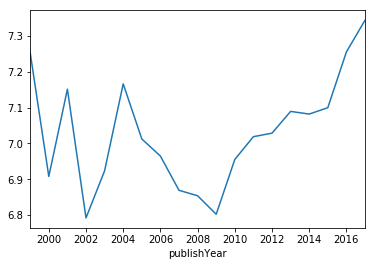

publishYear
1999    7.252632
2000    6.907831
2001    7.151376
2002    6.792109
2003    6.923596
2004    7.166219
2005    7.012488
2006    6.964683
2007    6.869179
2008    6.853942
2009    6.802290
2010    6.955256
2011    7.018857
2012    7.028571
2013    7.089357
2014    7.081885
2015    7.099723
2016    7.255181
2017    7.343731
Name: rating, dtype: float64

In [62]:
df['rating'] = df['rating'].astype(float) 
by_year = df.groupby('publishYear')
means = by_year.rating.agg('mean')
means.plot()
plt.show()
means

LinregressResult(slope=0.018344231537222252, intercept=-29.837197548424431, rvalue=0.068940995235880487, pvalue=9.7865934910307529e-19, stderr=0.0020732180357563475)


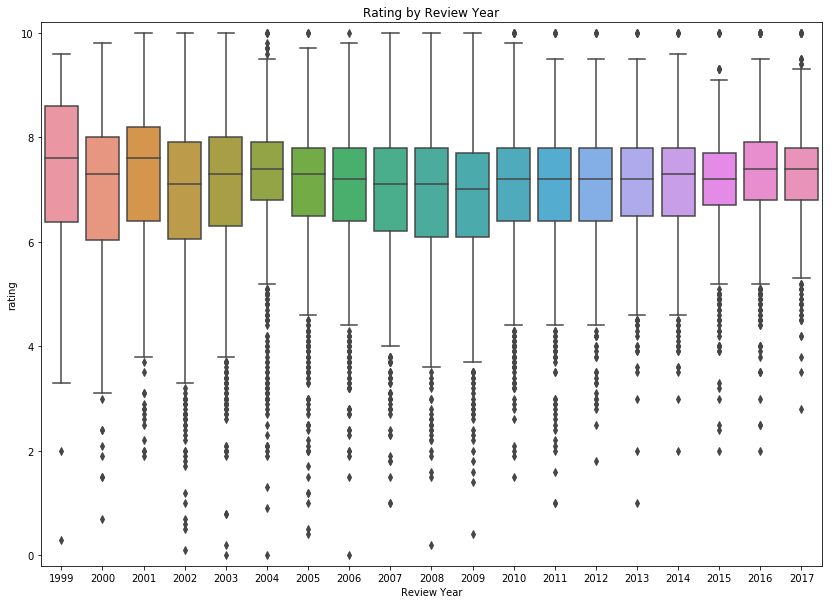

In [111]:
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'publishYear', y = 'rating',  data = df)

# add regression
reg = linregress(df.publishYear, df.rating)
print(reg)

x = np.arange(1998, 2018)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))

plt.xlabel('Review Year')
plt.title('Rating by Review Year')
plt.ylim([-0.2, 10.2])
plt.show()

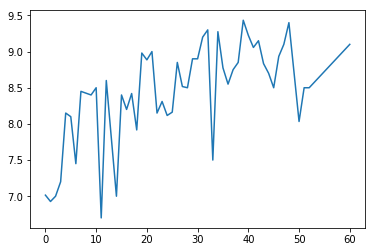

In [83]:
plt.clf()
zeroed = df[df['yearDiff'] >= 0]
yearDiff = zeroed.groupby('yearDiff').rating.agg('mean')
plt.plot(yearDiff.keys(), yearDiff.values)
plt.show()

LinregressResult(slope=0.0073482060422448278, intercept=6.9773550275678362, rvalue=0.019018786404125607, pvalue=0.014878190029589755, stderr=0.0030170152091357678)


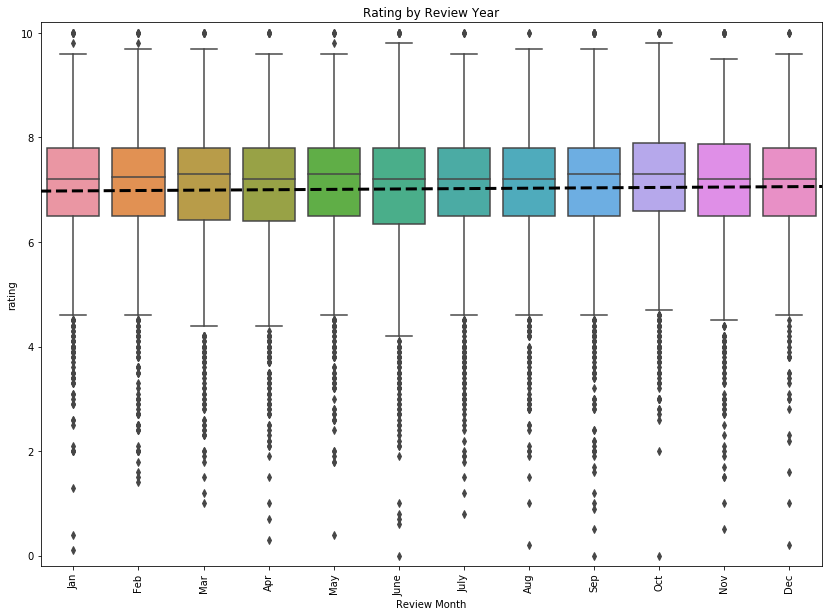

In [107]:
plt.clf()
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'publishMonth', y = 'rating',  data = df)

# add regression
reg = linregress(df.publishMonth, df.rating)
print(reg)

x = np.arange(-1, 13)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))

plt.xlabel('Review Month')
plt.title('Rating by Review Year')
plt.ylim([-0.2, 10.2])
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.arange(0, 12), labels, rotation='vertical')
plt.show()

LinregressResult(slope=0.013668316893654159, intercept=6.9937646131261708, rvalue=0.017901686031836197, pvalue=0.021890430833121203, stderr=0.0059622342825067761)


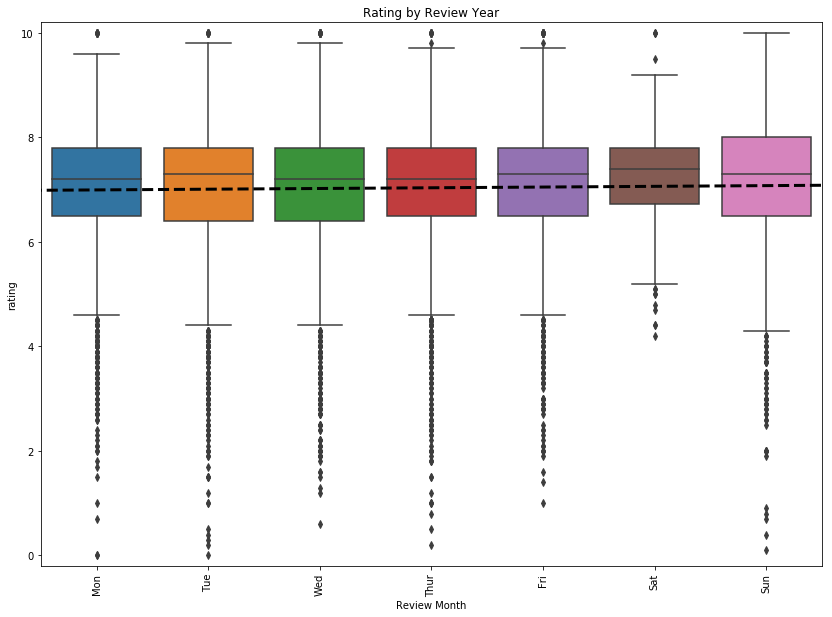

In [109]:
plt.clf()
plt.figure(figsize=(14, 10))

sns.boxplot(x = 'publishDay', y = 'rating',  data = df)

# add regression
reg = linregress(df.publishDay, df.rating)
print(reg)

x = np.arange(-1, 8)
y = reg.intercept + x*reg.slope
plt.plot(x,y,'--', color ='black', linewidth = 3,
    label = 'Regression, p = ' + str(round(reg.pvalue, 3)))

plt.xlabel('Review Month')
plt.title('Rating by Review Year')
plt.ylim([-0.2, 10.2])
labels = ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']
plt.xticks(np.arange(0, 7), labels, rotation='vertical')
plt.show()

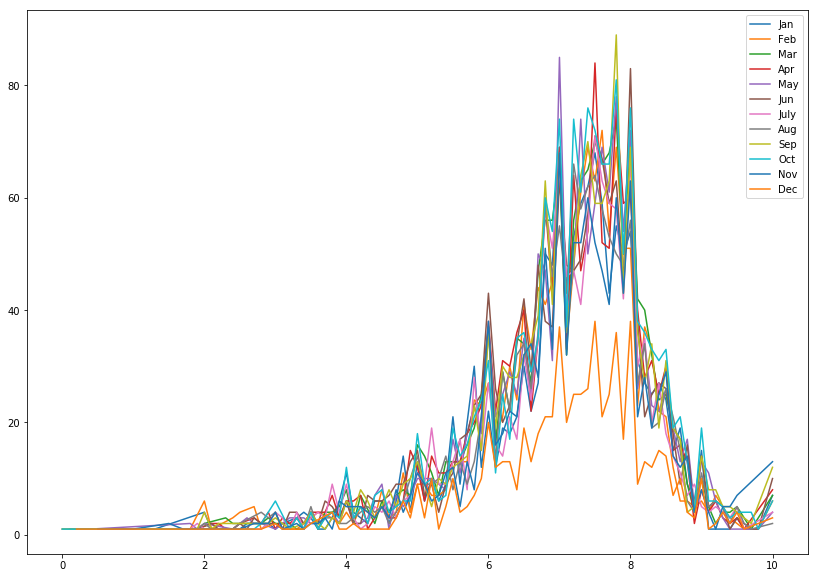

In [138]:
plt.clf()
plt.figure(figsize=(14, 10))

months =  df.groupby('publishMonth')
month_freq = months.rating.value_counts()
plt.plot(month_freq[1].sort_index(), label='Jan')
plt.plot(month_freq[2].sort_index(), label='Feb')
plt.plot(month_freq[3].sort_index(), label='Mar')
plt.plot(month_freq[4].sort_index(), label='Apr')
plt.plot(month_freq[5].sort_index(), label='May')
plt.plot(month_freq[6].sort_index(), label='Jun')
plt.plot(month_freq[7].sort_index(), label='July')
plt.plot(month_freq[8].sort_index(), label='Aug')
plt.plot(month_freq[9].sort_index(), label='Sep')
plt.plot(month_freq[10].sort_index(), label='Oct')
plt.plot(month_freq[11].sort_index(), label='Nov')
plt.plot(month_freq[12].sort_index(), label='Dec')

plt.legend(loc='best')
plt.show()

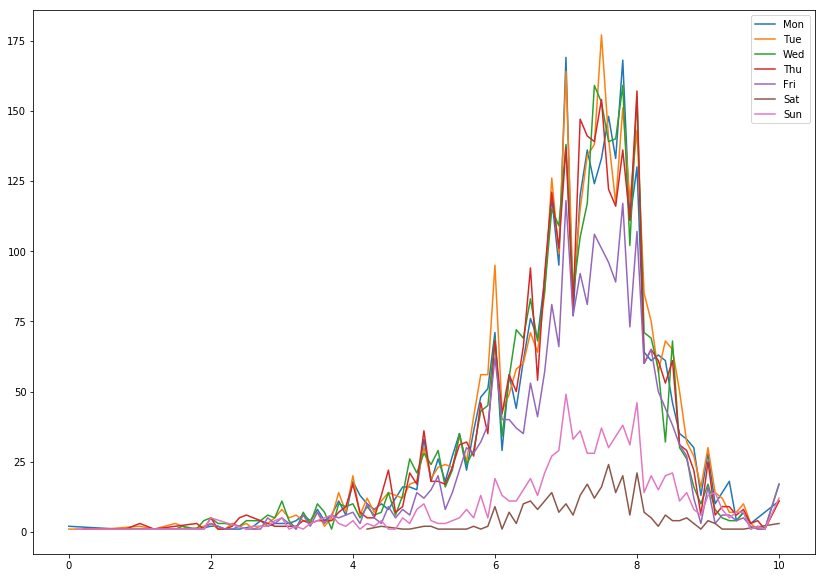

In [149]:
plt.clf()
plt.figure(figsize=(14, 10))

days =  df.groupby('publishDay')
day_freq = days.rating.value_counts()

plt.plot(day_freq[0].sort_index(), label='Mon')
plt.plot(day_freq[1].sort_index(), label='Tue')
plt.plot(day_freq[2].sort_index(), label='Wed')
plt.plot(day_freq[3].sort_index(), label='Thu')
plt.plot(day_freq[4].sort_index(), label='Fri')
plt.plot(day_freq[5].sort_index(), label='Sat')
plt.plot(day_freq[6].sort_index(), label='Sun')

plt.legend(loc='best')
plt.show()

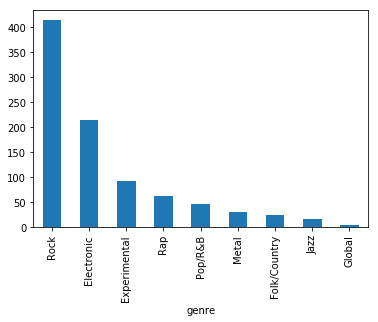

In [155]:
days =  df.groupby('publishDay')
day_freq = days.genre.value_counts()
day_freq[6].plot(kind='bar')
plt.show()

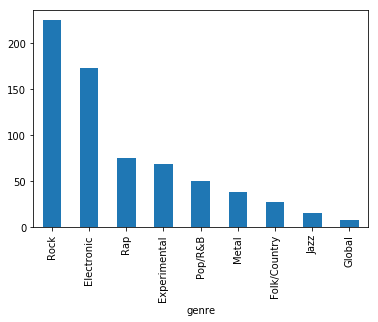

In [165]:
months =  df.groupby('publishMonth')
month_freq = months.genre.value_counts()
month_freq[12].plot(kind='bar')
plt.show()